## Detection of ORF regions from homology search


In [140]:
import os, sys
import pandas as pd
import math
import numpy as np
import re



command = "mafft-linsi ../03_Extended_homolog_search/HRR25_merged.fna > ./HRR25_mafft_linsi.txt"
#os.system(command)


# Evaluating gaps in the alignment file

In [141]:

def fasta2dict(f):
    d = {}
    with  open(f,"r") as F:
        for line in F:
            if line[0]==">":
                name = line[1:].split("\n")[0].split("|")[0]
                d[name] = ''
            else:
                #print(name)
                d[name]+= line.split("\n")[0]
    F.close()
    return d


def MSAdict2df_AA(d):
    """
    Dictionary of Multiple Sequence Alignment to pandas dataframe for evaluating gap regions.
    """
    n_entries = len(d)
    n_chars   = max([len(d[k]) for k in d])

    df = pd.DataFrame(data={k:list(d[k]) for k in d} )
    
    try:
        gap = df.apply(pd.Series.value_counts, axis=1).fillna(0)["-"]    
    except KeyError:
        gap = pd.Series(data=0, index=[i for i in range(n_chars)])
        
    
    df.insert(0,'Position', [i+1 for i in range(n_chars)])
    df.insert(1,'GapRatio', [(float(i)/float(n_entries)) for i in gap])
    df2 = df.swapaxes("index", "columns")
    return df2 



def MSAdict2df_nt(d):
    """
    Dictionary of Multiple Sequence Alignment to pandas dataframe for evaluating gap regions.
    """
    n_entries = len(d)-1
    n_chars   = max([len(d[k]) for k in d])

    df = pd.DataFrame(data={k:list(d[k]) for k in d} )
     
    try:
        gap = df.apply(pd.Series.value_counts, axis=1).fillna(0)["-"]    
    except KeyError:
        gap = pd.Series(data=0, index=[i for i in range(n_chars)])
    
    df.insert(0,'GapRatio', [(float(i+0)/float(n_entries)) for i in gap])
    
    df2 = df.swapaxes("index", "columns")
    #df2["Homolog"] = df2.index
    df2.reset_index(inplace = True)
    return df2 


def df2fasta(df,f):
    with open(f,"w") as F:
        for index, row in df.iterrows():
            gene = index
            seq  = ("").join([row[i] for i in df.columns.values.tolist()])
            entry = ">%s\n%s\n"%(gene,seq)
            F.write(entry)
        F.close()
    print("Generated fasta: %s"%(f))
        
    
def df2phy(df,f):
    nrow  = len(df.index)
    nchar = len(df. columns)
    df = df.drop(["Position"])
    
    with open(f,"w") as F:
        F.write("%d   %d\n\n"%(nrow,nchar))
        
        for index, row in df.iterrows():
            gene = index
            seq  = ("").join([row[i] for i in df.columns.values.tolist()])
            entry = "%s      %s\n"%(gene,seq)
            F.write(entry)
        F.close() 
        
    


def rev_comp(seq):
    complement_dict = {'A':'T','T':'A','G':'C','C':'G','N':'N'}
    return "".join([complement_dict[base.upper()] for base in reversed(seq)])

def translate_dna2aa(dna_seq):
    dna_seq = dna_seq.upper()
    codon_table = {
    'GCT':"A",
    'GCC':"A",
    'GCA':"A",
    'GCG':"A",
    'TGT':"C",
    'TGC':"C",
    'GAT':"D",
    'GAC':"D",
    'GAA':"E",
    'GAG':"E",
    'TTT':'F',
    'TTC':'F',
    'GGT':'G',
    'GGC':'G',
    'GGA':'G',
    'GGG':'G',
    'CAT':'H',
    'CAC':'H',
    'ATT':'I',
    'ATC':'I',
    'ATA':'I',
    'AAA':'K',
    'AAG':'K',
    'TTA':'L',
    'TTG':'L',
    'CTT':'L',
    'CTC':'L',
    'CTA':'L',
    'CTG':'L',
    'ATG':'M',
    'AAT':'N', 'AAC':'N',
    'CCT':'P', 'CCC':'P', 'CCA':'P', 'CCG':'P',
    'CAA':'Q', 'CAG':'Q',
    'CGT':'R', 'CGC':'R', 'CGA':'R', 'CGG':'R', 'AGA':'R', 'AGG':'R',
    'TCT':'S', 'TCC':'S', 'TCA':'S', 'TCG':'S', 'AGT':'S', 'AGC':'S',
    'ACT':'T', 'ACC':'T', 'ACA':'T', 'ACG':'T',
    'GTT':'V', 'GTC':'V', 'GTA':'V', 'GTG':'V',
    'TGG':'W',
    'TAT':'Y', 'TAC':'Y',
    'TAG':"*",'TGA':"*",'TAA':"*",

    #Inverse table for the standard genetic code (compressed using IUPAC notation)
    'GCN':"A",
    'CGN':"R",'AGR':"R",'CGY':"R",'MGR':"R",
    'AAY':"N",
    'GAY':"D",
    'RAY':"B",
    'TGY':"C",
    'CAR':"Q",
    'GAR':"E",
    'SAR':"Z",
    'GGN':"G",
    'CAY':"H",
    'ATH':"I",
    'CTN':"L",'TTR':"L",'CTY':"L",'YTR':"L",
    'AAR':"K",
    'TTY':"F",
    'CCN':"P",
    'TCN':"S",'AGY':"S",
    'ACN':"T",
    'TAY':"Y",
    'GTN':"V",
    'TRA':"*",'TAR':"*"
                }

    aa_seq = ""
    for i in range(1,int(len(dna_seq)/3)+1):
        try:
            aa_seq += codon_table[dna_seq[(i-1)*3:i*3]]
        except KeyError:
            #print("Undefined codon: '%s' was translated to X "%(dna_seq[(i-1)*3:i*3]))
            aa_seq += 'X'
    return(aa_seq)

def fasta2dict(f):
    d = {}
    with  open(f,"r") as F:
        for line in F:
            if line[0]==">":
                name = line[1:].split("\n")[0].split("|")[0]
                d[name] = ''
            else:
                #print(name)
                d[name]+= line.split("\n")[0]
    F.close()

    return d

        


def make_fasta_from_listoftups(L,name):
    with open("%s"%name,"w") as f:
        for I in L:
            #print I
            f.write('>%s\n'%(str(I[0])))
            f.write('%s\n'%(str(I[1])))
        f.close()
        #print("Made fna file : %s"%(name))


def get_blastout(x):
    files = []
    lis = os.listdir("%s" %x)
    for i in lis:
        if i[-4:] == ".out" :
            files.append(i)
    return list(files)

def parse_blastout(dir_out):
    lis = os.listdir(dir_out)
    fs = ["%s/%s" %(dir_out,f) for f in lis]
    D = {}
    for f in fs:
        if f.split("/")[-1][0] != ".":
            genome = f.split("/")[-1].split(".blast")[0]
            with open(f, "r") as F:
                hit_n = 0
                for line in F:
                    hit_n+=1
                    hit         = hit_n   
                    cols        =    line.split(",")
                    contig      =    cols[0]
                    subject     =    cols[1]
                    bit         =    float(cols[2])
                    str_on_q    =    int(cols[6])
                    end_on_q    =    int(cols[7])
                    str_on_s    =    int(cols[8])
                    end_on_s    =    int(cols[9])
                    evalue      =    float(cols[10])


                    el = {}
                    el["contig"]   = contig
                    el["subject"]    = subject
                    el["str_s"]      = str_on_s
                    el["end_s"]      = end_on_s
                    el["str_q"]      = str_on_q
                    el["end_q"]      = end_on_q
                    el["evalue"]   = evalue
                    el["bitscore"] = bit
                    try:
                        D[genome][hit] = el
                    except KeyError:        
                        D[genome] = {}
                        D[genome][hit] = el

            F.close()
    return D    


In [142]:
# Reference genes used as query for homology search
query_homologs = fasta2dict("../03_Extended_homolog_search/blast/db/HRR25_nuc_nonAligned.fasta")
query          = list(query_homologs.keys())

In [143]:
mafft_out = "HRR25_mafft_linsi.txt"
msa_d     = fasta2dict(mafft_out)
msa_df = MSAdict2df_nt(msa_d)
msa_df.head()



,index,0,1,2,3,4,5,6,7,8,...,10513,10514,10515,10516,10517,10518,10519,10520,10521,10522
0,GapRatio,0.714286,0.714286,0.714286,0.714286,0.714286,0.807143,0.835714,0.835714,0.835714,...,1.0,0.992857,1.0,0.985714,0.978571,0.971429,0.971429,0.964286,0.964286,0.964286
1,GCA_030569995.1_ASM3056999v1_genomic.fna_Conti...,a,t,g,c,a,a,c,c,a,...,-,-,-,-,-,-,-,-,-,-
2,tetrapisispora_phaffii.fas_Contig:NC_016524.1_...,-,-,-,-,-,-,-,-,-,...,-,-,-,t,a,t,g,a,t,t
3,tetrapisispora_phaffii.fas_Contig:NC_016529.1_...,a,t,g,g,t,t,g,t,g,...,-,-,-,-,-,-,-,-,-,-
4,GCA_900074765.1_LAFE0_genomic.fna_Contig:LT598...,-,-,-,-,-,-,-,-,-,...,-,a,c,c,c,t,t,g,g,t


In [144]:
df_query = msa_df[msa_df['index'].isin(query)]
df_query.head()


,index,0,1,2,3,4,5,6,7,8,...,10513,10514,10515,10516,10517,10518,10519,10520,10521,10522
93,Saccharomyces_pastorianus_GRS66_005211,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
94,Saccharomyces_pastorianus_GRS66_010945,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
95,Saccharomyces_cerevisiae_YPL204W,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
96,Saccharomyces_eubayanus_DI49_5263,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
97,Saccharomyces_bayanus_var.uvarum_Suva_16.102,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [145]:
len(df_query)

49

In [146]:
occurance_count = df_query.apply(pd.Series.value_counts, axis='rows').fillna(0)

occurance_count2 = occurance_count.swapaxes("index", "columns")

#count_gaps = occurance_count.loc['-']
#count_gaps.head()
occurance_count2["Pos"] = occurance_count2.index
occurance_count2= occurance_count2.drop(index=["index"])
occurance_count2.head()

,-,Eremothecium_cymbalariae_Ecym_2202,Eremothecium_gossypii_AGOS_AFL091W,Kazachstania_africana_KAFR_0C02290,Kazachstania_africana_KAFR_0K00320,Kazachstania_barnettii_KABA2_04S02882,Kazachstania_barnettii_KABA2_06S03410,Kazachstania_exigua_HRR25_1,Kazachstania_exigua_HRR25_2,Kazachstania_naganishii_KNAG_0D01130,...,Zygosaccharomyces_bailii_FUGC01000003.1_cds_SJM83735.1_1,Zygosaccharomyces_parabailii_ZPAR0C01310_A,Zygosaccharomyces_parabailii_ZPAR0K01220_B,Zygosaccharomyces_rouxii_ZYRO0G08866g,Zygotorulaspora_mrakii_HG535_0B00830,a,c,g,t,Pos
0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


<AxesSubplot:xlabel='Pos'>

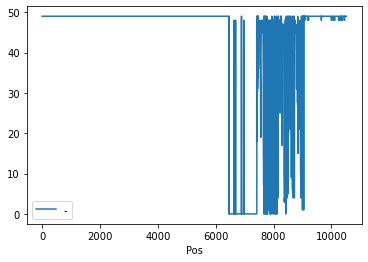

In [147]:
import matplotlib.pyplot as plt
occurance_count2.plot(x="Pos", y="-", kind="line")

In [148]:
occurance_count2.loc[occurance_count2['-'] < 45]

# identified start codon position as position 6499 of alignment

,-,Eremothecium_cymbalariae_Ecym_2202,Eremothecium_gossypii_AGOS_AFL091W,Kazachstania_africana_KAFR_0C02290,Kazachstania_africana_KAFR_0K00320,Kazachstania_barnettii_KABA2_04S02882,Kazachstania_barnettii_KABA2_06S03410,Kazachstania_exigua_HRR25_1,Kazachstania_exigua_HRR25_2,Kazachstania_naganishii_KNAG_0D01130,...,Zygosaccharomyces_bailii_FUGC01000003.1_cds_SJM83735.1_1,Zygosaccharomyces_parabailii_ZPAR0C01310_A,Zygosaccharomyces_parabailii_ZPAR0K01220_B,Zygosaccharomyces_rouxii_ZYRO0G08866g,Zygotorulaspora_mrakii_HG535_0B00830,a,c,g,t,Pos
6460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,0.0,6460
6461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,6461
6462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,1.0,6462
6463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,6463
6464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,48.0,0.0,1.0,0.0,6464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9039,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,46.0,9039
9040,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,28.0,1.0,17.0,2.0,9040
9041,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,47.0,9041
9042,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,42.0,0.0,6.0,0.0,9042


In [149]:
# creating nucleotide sequence based on start codon & translated sequence

prot_regions = []
dna_regions  = []

pos = 6460
test = list(msa_d.keys())[:10]              

max_p_len = 0

for entry in msa_d:
    seq = msa_d[entry][pos::].replace("-","").upper()
    # Adjust strat position 
    i = 1
    
    # if out of frame and/or not having in-frame AtG, find it 
    if (seq[:3] != "ATG"):
        correct= 0
        for i in range(1,pos+30):
            if correct !=1:           
                seq = msa_d[entry][pos+30-i::].replace("-","").upper()
                if (seq[:3] != "ATG"):
                    pass
                else:
                    correct =1
            else:
                pass
                
    prot_seq     = translate_dna2aa(seq)
    p_len = len(prot_seq.split("*")[0])
    if p_len > max_p_len:
        max_p_len = p_len
    dna_seq      = seq
    
    dna_regions.append((entry,dna_seq))    
    prot_regions.append((entry,prot_seq))


for i in range(len(prot_regions)):
    #print(prot_regions[i][1])
    if len(prot_regions[i][1])>max_p_len:
        prot_regions[i] = (prot_regions[i][0],prot_regions[i][1][:max_p_len])
        dna_regions[i]  =  (dna_regions[i][0],dna_regions[i][1][:(max_p_len*3)])
        
    
    
    
make_fasta_from_listoftups(prot_regions,"HRR25_homologs_aa_trimmed.fna")
make_fasta_from_listoftups(dna_regions,"HRR25_homologs_nt_trimmed.fna")

In [151]:
dataList = list(dna_regions)
df = pd.DataFrame(
      dataList, columns=['Name', 'Seq'])

df[['Genome', 'Contig']] = df.Name.str.split("_Contig:", expand = True)
df[['Contig', 'Pos']] = df.Contig.str.split("_Pos:", expand = True)
df[['Pos', 'Strand']] = df.Pos.str.split("_Strand:", expand = True)
df.to_csv("HRR25_trimed_nt_info.csv")



dataList = list(prot_regions)
df = pd.DataFrame(
      dataList, columns=['Name', 'Seq'])
df[['Genome', 'Contig']] = df.Name.str.split("_Contig:", expand = True)
df[['Contig', 'Pos']] = df.Contig.str.split("_Pos:", expand = True)
df[['Pos', 'Strand']] = df.Pos.str.split("_Strand:", expand = True)
df.to_csv("HRR25_trimed_aa_info.csv")